<a href="https://colab.research.google.com/github/mnansary/pyF2O/blob/master/colab_gen_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
for i in range(0,1,1):
    print(i)

0


# colab specific task
*   Check TF version
*   mount google drive
*   GPU check
*   Change Working Directory to cloned dir 

NOTE: **git clone the repo before running this notebook**

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
tf.__version__


TensorFlow 2.x selected.
Found GPU at: /device:GPU:0


'2.0.0'

In [3]:
cd /content/gdrive/My\ Drive/PROJECTS/F2O/pyF2O/

/content/gdrive/My Drive/PROJECTS/F2O/pyF2O


# GCS specific task 
* **auth user**
* set project information


In [0]:
# auth user for cloud SDK
from google.colab import auth
auth.authenticate_user()

#### SET PROJECT INFORMATION 

In [5]:
PROJECT_ID    ='f2oitpu'               # @param 
BUCKET        ='f2odata'               # @param 

# LIST FILES
TFRECORDS_DIR= 'gs://{}/{}/'.format(BUCKET,'tfrecord')
CHECKPOINT_DIR    = 'gs://{}/{}/'.format(BUCKET,'checkpoints')
# change TFRECORDS_DIR specific to structre
#
!gcloud config set project {PROJECT_ID}
!gsutil ls {TFRECORDS_DIR}
!gsutil ls gs://{BUCKET}


Updated property [core/project].
gs://f2odata/tfrecord/test/
gs://f2odata/tfrecord/train/
gs://f2odata/checkpoints/
gs://f2odata/model_dir/
gs://f2odata/tfrecord/


# pix2pix
* Define the **Optimizers** and **Checkpoint-saver** 
* Set **train and test dataset**

#### Optimizers,Flags,Check-point Saver

In [0]:
import os
from F2O.pix2pix_src import Generator,Discriminator

class FLAGS:
    IMAGE_DIM       = 256       # @param
    NB_CHANNELS     = 3         # @param
    BATCH_SIZE      = 1       # @param
    SHUFFLE_BUFFER  = 400      # @param    
    LEARNING_RATE   = 2e-4    # @param
    
# optimizers
generator_optimizer = tf.keras.optimizers.Adam(FLAGS.LEARNING_RATE,
                                               beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(FLAGS.LEARNING_RATE,
                                                   beta_1=0.5)
# Models
generator=Generator(IMAGE_DIM=FLAGS.IMAGE_DIM,
                    NB_CHANNELS=FLAGS.NB_CHANNELS)
discriminator=Discriminator(IMAGE_DIM=FLAGS.IMAGE_DIM,
                    NB_CHANNELS=FLAGS.NB_CHANNELS)
# checkpoint
checkpoint_prefix = os.path.join(CHECKPOINT_DIR, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
# summary writer
import datetime
log_dir="logs/" #@param

summary_writer = tf.summary.create_file_writer(log_dir + 
                                               "fit/" + 
                                               datetime.datetime.now().strftime(
                                               "%Y%m%d-%H%M%S")
                                               )

#### Train Step

In [0]:
from F2O.pix2pix_src import generator_loss,discriminator_loss
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)

#### DataSets
 

In [8]:
from google.cloud import storage
from functools import partial

client = storage.Client(PROJECT_ID)
# get bucket from the project
bucket=client.get_bucket(BUCKET)
print(bucket)

def data_input_fn(FLAGS,mode): 
    
    def _parser(example):
        feature ={  'image'  : tf.io.FixedLenFeature([],tf.string) ,
                    'target' : tf.io.FixedLenFeature([],tf.string)
        }    
        parsed_example=tf.io.parse_single_example(example,feature)
        image_raw=parsed_example['image']
        image=tf.image.decode_png(image_raw,channels=FLAGS.NB_CHANNELS)
        image=tf.cast(image,tf.float32)/255.0
        image=tf.reshape(image,(FLAGS.IMAGE_DIM,FLAGS.IMAGE_DIM,FLAGS.NB_CHANNELS))
        
        target_raw=parsed_example['target']
        target=tf.image.decode_png(target_raw,channels=FLAGS.NB_CHANNELS)
        target=tf.cast(target,tf.float32)/255.0
        target=tf.reshape(target,(FLAGS.IMAGE_DIM,FLAGS.IMAGE_DIM,FLAGS.NB_CHANNELS))
        return image,target

    dataset = tf.data.TFRecordDataset([os.path.join('gs://{}/'.format(BUCKET), f.name) for f in bucket.list_blobs(prefix='tfrecord/{}'.format(mode))])
    dataset = dataset.map(_parser)
    if mode=='train':
      dataset = dataset.shuffle(FLAGS.SHUFFLE_BUFFER)
    dataset = dataset.batch(FLAGS.BATCH_SIZE,drop_remainder=True)
    return dataset

train_ds = data_input_fn(FLAGS=FLAGS,mode='train')
test_ds  = data_input_fn(FLAGS=FLAGS,mode='test')




<Bucket: f2odata>


#### Training loop

* Iterates over the number of epochs.
* On each epoch it clears the display, and runs `generate_images` to show it's progress.
* On each epoch it iterates over the training dataset, printing a '.' for each example.
* It saves a checkpoint every 20 epochs.

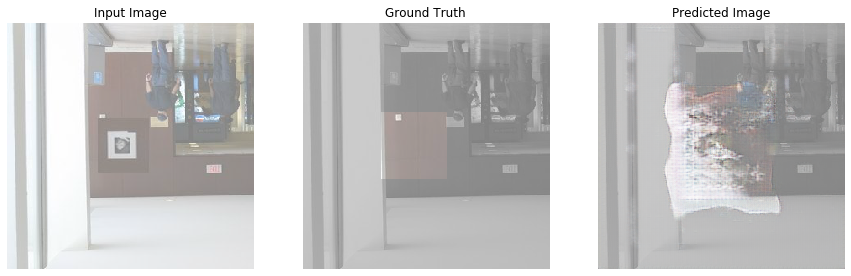

Epoch:  1
data=99
data=199
data=299
data=399
data=499
data=599
data=699
data=799
data=899
data=999
data=1099
data=1199
data=1299
data=1399
data=1499
data=1599
data=1699
data=1799
data=1899
data=1999
data=2099
data=2199
data=2299
data=2399
data=2499
data=2599
data=2699
data=2799
data=2899
data=2999
data=3099
data=3199
data=3299
data=3399
data=3499
data=3599
data=3699
data=3799

data=3999
data=4099
data=4199
data=4299
data=4399
data=4499
data=4599
data=4699
data=4799
data=4899
data=4999
data=5099
data=5199
data=5299
data=5399
data=5499
data=5599
data=5699
data=5799
data=5899
data=5999
data=6099

data=6299
data=6399
data=6499
data=6599
data=6699
data=6799
data=6899
data=6999
data=7099
data=7199
data=7299


KeyboardInterrupt: ignored

In [10]:
import time
from IPython import display
from matplotlib import pyplot as plt
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()


def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      print('data={}'.format(n), end='\r')
      if (n+1) % 100 == 0:
        print()
      train_step(input_image, target, epoch)
    print()

    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  checkpoint.save(file_prefix = checkpoint_prefix)
EPOCHS=10 #@param
fit(train_ds, EPOCHS, test_ds)